In [3]:
import numpy as np
import scipy
import pickle
from tensornetwork import ncon
import matplotlib.pyplot as plt
from IPython.display import clear_output
import mps
import tebd
import mpmath
import math
import seaborn as sns

In [5]:
# Calculate ground state energies with TEBD
deltas_tebd = np.linspace(-3, 3, 30)
egs_tebd = np.zeros_like(deltas_tebd)

d = 2
sx, sy, sz = tebd.generate_spin_operators((d - 1) / 2)

for i, delta in enumerate(deltas_tebd):
    print(i)
    # Initialise MPS
    N = 20
    chi = 16
    mps_tensors, weights = mps.initialise_random_mps(N, d, chi)

    # Compute nearest-neighbour hamiltonian
    nn_hamiltonian = -(np.kron(sx, sx) + np.kron(sy, sy) + delta * np.kron(sz, sz))

    # Evolve state in imaginary time using TEBD
    imag_gate = scipy.linalg.expm(- 0.1 * nn_hamiltonian).reshape(d, d, d, d)
    for k in range(50):
        mps_tensors, weights = tebd.do_tebd_timesteps(10, imag_gate, mps_tensors, weights, max_chi_trunc=16)
        mps_tensors, weights = tebd.do_tebd_midstep(mps_tensors, weights, nn_hamiltonian)

    # Reduce timestep
    imag_gate = scipy.linalg.expm(- 0.01 * nn_hamiltonian).reshape(d, d, d, d)
    for k in range(20):
        mps_tensors, weights = tebd.do_tebd_timesteps(100, imag_gate, mps_tensors, weights, max_chi_trunc=16)
        mps_tensors, weights = tebd.do_tebd_midstep(mps_tensors, weights, nn_hamiltonian)

    rhos = mps.reduced_density_matrices(mps_tensors, weights)
    energy = ncon([nn_hamiltonian.reshape((d, d, d, d)), np.array(rhos)], [[1,2,3,4], [5,1,2,3,4]])
    egs_tebd[i] = energy.real / N  # Ground-state energy per site
    clear_output()

In [9]:
with open('./data/imag_tebd.pkl', 'wb') as f:
    pickle.dump((deltas_tebd, egs_tebd), f)

In [6]:
# Calculate analytical ground state energies
eps = 3e-6  # Small epsilon to avoid divergence at phase boundaries
num_samples = 100

# Anti-ferromagnetic phase
deltas_antiferro = np.linspace(-3, -1 - eps, num_samples)
lambdas_antiferro = np.arccosh(-deltas_antiferro)
egs_antiferro = np.zeros_like(deltas_antiferro)
for i, l in enumerate(lambdas_antiferro):
    inf_sum = mpmath.nsum(lambda n: 1 / (1 + math.exp(2 * l * n)), [1, mpmath.inf])
    egs_antiferro[i] = np.cosh(l) / 4 - np.sinh(l) / l * (l / 2 + 2 * l * inf_sum)

# Paramagnetic phase
deltas_para = np.linspace(-1 + eps, 1 - eps, num_samples)
mus_para = np.arccos(-deltas_para)
egs_para = np.zeros_like(deltas_para)
for i, mu in enumerate(mus_para):
    def integrand(x, mu):
        return (
            mu
            * np.sin(mu)
            / (2 * np.cosh(np.pi * x) * (np.cosh(2 * mu * x) - np.cos(mu)))
        )
    integral, err = scipy.integrate.quad(integrand, -np.inf, np.inf, args=(mu))
    egs_para[i] = np.cos(mu) / 4 - np.sin(mu) / mu * integral

# Ferromagnetic phase
deltas_ferro = np.linspace(1, 3, num_samples)
egs_ferro = -deltas_ferro / 4

deltas_analytical = np.concatenate((deltas_antiferro, deltas_para, deltas_ferro))
egs_analytical = np.concatenate((egs_antiferro, egs_para, egs_ferro))

/var/folders/9k/h_wrkckj3pg29k07vcmrbq3w0000gn/T/ipykernel_81572/3434730275.py:22: RuntimeWarning: overflow encountered in cosh
  / (2 * np.cosh(np.pi * x) * (np.cosh(2 * mu * x) - np.cos(mu)))
/var/folders/9k/h_wrkckj3pg29k07vcmrbq3w0000gn/T/ipykernel_81572/3434730275.py:22: RuntimeWarning: overflow encountered in scalar multiply
  / (2 * np.cosh(np.pi * x) * (np.cosh(2 * mu * x) - np.cos(mu)))


In [7]:
with open('./data/imag_tebd.pkl', 'rb') as f:
    deltas_tebd, egs_tebd = pickle.load(f)

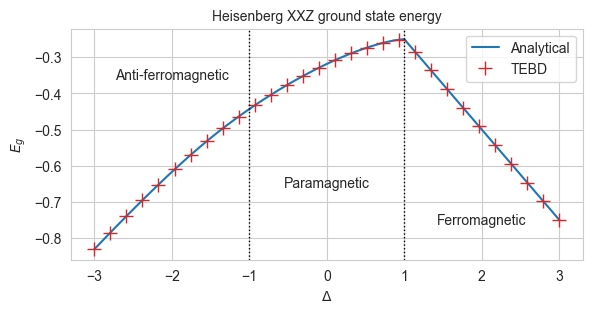

In [8]:
sns.set_style("whitegrid")
colors = sns.color_palette()

fig, ax0 = plt.subplots(figsize=(6.6, 3))
ax0.set_xlabel(r'$\Delta$', fontsize=10)
ax0.set_ylabel(r'$E_g$', fontsize=10)

ax0.plot(deltas_analytical, egs_analytical, color=colors[0], label='Analytical')
ax0.plot(deltas_tebd, egs_tebd, '+', color=colors[3], markersize=10, label='TEBD')
ax0.axvline(-1, color='k', linestyle=':', linewidth=1)
ax0.axvline(1, color='k', linestyle=':', linewidth=1)
ax0.text(-2, -0.35, 'Anti-ferromagnetic', ha='center', va='center', fontsize=10)
ax0.text(0, -0.65, 'Paramagnetic', ha='center', va='center', fontsize=10)
ax0.text(2, -0.75, 'Ferromagnetic', ha='center', va='center', fontsize=10)
ax0.legend(fontsize=10)
ax0.set_title('Heisenberg XXZ ground state energy', fontsize=10);
# plt.savefig('./Report/figures/ground_state_energy.pdf', bbox_inches='tight')

In [9]:
# Find TEBD errors
eps = 3e-6  # Small epsilon to avoid divergence at phase boundaries
num_samples = 100

# Anti-ferromagnetic phase
deltas_antiferro = deltas_tebd[deltas_tebd < (-1 - eps)]
lambdas_antiferro = np.arccosh(-deltas_antiferro)
egs_antiferro = np.zeros_like(deltas_antiferro)
for i, l in enumerate(lambdas_antiferro):
    inf_sum = mpmath.nsum(lambda n: 1 / (1 + math.exp(2 * l * n)), [1, mpmath.inf])
    egs_antiferro[i] = np.cosh(l) / 4 - np.sinh(l) / l * (l / 2 + 2 * l * inf_sum)

# Paramagnetic phase
deltas_para = deltas_tebd[(deltas_tebd > (-1 + eps)) & (deltas_tebd < (1 - eps))]
mus_para = np.arccos(-deltas_para)
egs_para = np.zeros_like(deltas_para)
for i, mu in enumerate(mus_para):
    def integrand(x, mu):
        return (
            mu
            * np.sin(mu)
            / (2 * np.cosh(np.pi * x) * (np.cosh(2 * mu * x) - np.cos(mu)))
        )
    integral, err = scipy.integrate.quad(integrand, -np.inf, np.inf, args=(mu))
    egs_para[i] = np.cos(mu) / 4 - np.sin(mu) / mu * integral

# Ferromagnetic phase
deltas_ferro = deltas_tebd[deltas_tebd >= 1]
egs_ferro = -deltas_ferro / 4

deltas_tebd_analytical = np.concatenate((deltas_antiferro, deltas_para, deltas_ferro))
egs_tebd_analytical = np.concatenate((egs_antiferro, egs_para, egs_ferro))

/var/folders/9k/h_wrkckj3pg29k07vcmrbq3w0000gn/T/ipykernel_81572/2220178568.py:22: RuntimeWarning: overflow encountered in cosh
  / (2 * np.cosh(np.pi * x) * (np.cosh(2 * mu * x) - np.cos(mu)))
/var/folders/9k/h_wrkckj3pg29k07vcmrbq3w0000gn/T/ipykernel_81572/2220178568.py:22: RuntimeWarning: overflow encountered in scalar multiply
  / (2 * np.cosh(np.pi * x) * (np.cosh(2 * mu * x) - np.cos(mu)))


In [14]:
errors = np.abs((egs_tebd - egs_tebd_analytical) / egs_tebd_analytical)
print(errors.mean())

3.934490183814196e-05
